## LCM Model:

W ---> l <---- U ----> Y <---- Phi and l --> L

U is the latent process that generates both Ls and Ys here Ls are 0s and 1s and Y are gaussian processes

here also we introduce S trials for each Y. To accomodate these we fold up Y's in vectorized form
#### Now, $Y \in R^{S \times CN}, u \in R^{S \times PN }$ and ${ \bar{\phi} }$ is a block diagonal of size CN X PN with CXP matrix ${\phi}$ on diagonals. Also $W \in R^{1 \times PN}$ 

###  $Y= u * \bar{\phi}^T + \sigma^2I$
###  $l= b + u * W^T + s^2I$
####  L = -1 if l < $\mu$ L = +1 otherwise 

here b is the bias and s denotes the noise in label generation process


##### Also, $u \in GP(0,\bar{K})$ where $\bar{K}$ is also a blaock diagonal of size PN x PN with covariance kernels ${K_p \in R ^{N \times N}}$ for each  gaussian process on diagonals.

In [1]:
### necessary Imports
import numpy as np
import pylab as pb
import scipy as sc
from matplotlib import pyplot as plt
from scipy.stats import multivariate_normal as MNormalDist
import GPy
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
def guessLabel(l,mu=0):
    if l < mu:
        return -1
    else:
        return 1
def scale(d):
    return (d - d.min())/(d.max() - d.min())

#### Load training Data
    -Training data consists of 40% linear and 60% gaussian proceeses with C =1
    - We have split the data into training and test sets already

In [5]:
import pickle
f = open("Y_train.pickle","rb")
YBar = pickle.load(f)
f.close()
f = open("L_train.pickle","rb")
L = pickle.load(f)
f.close()
f = open("Y_test.pickle","rb")
Y_test = pickle.load(f)
f.close()
f = open("L_test.pickle","rb")
L_test = pickle.load(f)
f.close()

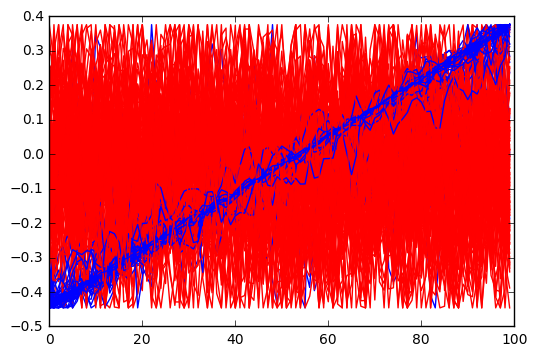

In [6]:
def plotLabel(YBar,L,S):
    for s in range(S):
        if L[s] < 0:
            plt.plot(YBar[s].T,c='r')
        else:
            plt.plot(YBar[s].T,c='b')
plotLabel(YBar,L,YBar.shape[0])

In [7]:
C = 1
N = YBar.shape[1]
S = YBar.shape[0]
x = np.linspace(0,N-1,N)

### Inference: 

#### Initializations:

Concatenated Latent Gaussian Processes:
(240, 240) (180, 240, 1)


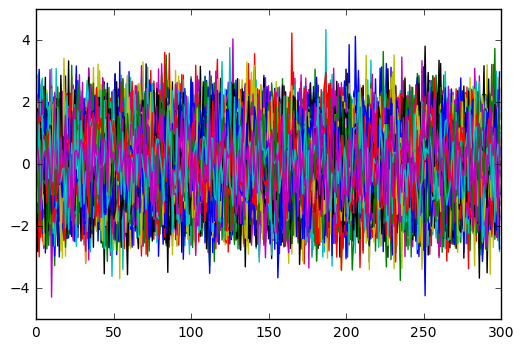

In [8]:
## get random inducing point
## Intialization for variational inference
P=3
noOfInductions = int(N*0.8)
n = sort(np.random.choice(x,size=noOfInductions,replace=False))
nBar = np.concatenate([c*N+n for c in range(C)])
NBar = np.concatenate([c*N+x for c in range(C)])
# Create Matrices
Knn = list()
KNn = list()
KnnInv = list()
KNN = list()
ls = [2,2,2,2,2]
for i in range(P):
    kenrel = GPy.kern.ExpQuad(1,lengthscale=ls[i]) #+ kenrel2
    Knn.append(kenrel.K(n.reshape(noOfInductions,1))+np.eye(noOfInductions)*0.0)
    KNn.append(kenrel.K(x.reshape(N,1), n.reshape(noOfInductions,1)))
    KNN.append(kenrel.K(x.reshape(N,1))+np.eye(N)*0.00)
    KnnInv.append(np.linalg.inv(Knn[i]))
Kpnn = np.matrix(sc.linalg.block_diag(*Knn))
KpNn = np.matrix(sc.linalg.block_diag(*KNn))
KpnnInv = np.matrix(sc.linalg.block_diag(*KnnInv))
KpNN = np.matrix(sc.linalg.block_diag(*KNN))
# Generate a guess for phi
phiHatMean = 0
phiHatV = 1
phiHatExp = np.mat(np.random.normal(loc=phiHatMean,scale=phiHatV,size=(C,P)))
phiHatExpBar = np.kron(phiHatExp,np.eye(N))
phiHatVar = np.eye(P)
# Generate a guess for B
BHatMean = 0
BHatV = 1
BHatExp = np.mat(np.random.normal(loc=BHatMean,scale=BHatV,size=(S,1)))
# Generate a guess for W
WHatMean = 0
WHatV = 1
WHatExp = np.mat(np.random.normal(loc=WHatMean,scale=WHatV,size=(1,P*N)))
WHatV = np.eye(P*N)
#Generate samples for latent
uHatMeansBar = np.random.normal(loc=0,scale=1,size=(S,noOfInductions*P,1))
uHatVsBar = np.eye(noOfInductions*P)
uExpBar = np.random.normal(loc=0,scale=1,size=(S,N*P))
print "Concatenated Latent Gaussian Processes:"
i=plt.plot(uExpBar.T)
print uHatVsBar.shape,uHatMeansBar.shape
## Generate Sample for latent labels
lHatExp = (uExpBar * WHatExp.T) + BHatExp
## Get initial label guess
LHat = np.ones(S)
LHat = [guessLabel(lHatExp[s]) for s in range(S)]

### Variational Updates are:

#### For ${\hat{u}}$:

$q(\hat{u}) \propto N(\hat{u}|(y<\phi> + <w><l>\sigma^2 - <w><b>\sigma^2){K}_{pNpn}K_{pn}^{-1}\Sigma_{u}^{-1}, \hat{\Sigma}_{u}^{-1})$
where $ \hat{\Sigma}_{u} = K_{pn}^{-1} + \frac{1}{\sigma^2}K_{pn}^{-1}K_{pnpN}F_uK_{pNpn}K_{pn}^{-1}$
and $F_u = <{\phi}^T{\phi}>_{\phi} + \sigma^2<w^Tw>_w = Var(\phi) + <\phi>^T<\phi> + Var(w) + <w>^T<w>$ , 

#### For ${u}$:

${q(u) \propto N (\hat{\mu}M, \Sigma_{u|u^{p}} + M\Sigma_{u}M^{T})}$


where $\hat{\mu}_{u}$ is the mean and ${\hat{\Sigma}_{u}}$ variance of $\hat{u}$

Also  $\Sigma_{u|u^{p}} = K_{pNpN} - K_{pNpn}K_{pn}^{-1}K_{pnpN}$ , $M = K_{pn}^{-1}K_{pNpn}$

#### For $\phi$:

$\phi = N(\phi| (\bar{V}_{\phi} + I)^{-1}\bar{z}_{\phi}, (\bar{V}_{\phi} + I)^{-1})$
where $\bar{V}_{\phi} = \sum_{s}^{S}(<\bar{u}_s><\bar{u}_s>^T$ + I)
and $\bar{z}_{\phi} = \sum_{s}^{S}<\bar{u}_s>\bar{y}_{s}^T$
here $x = vec(\bar{x})$ 

#### For l:

$q(l_i) \propto TN(l_i| (<w><u> + <b>, 2*I, l_i < \mu)$
where TN is truncated normal distribution

#### For W:

$W \propto N(w | [F_u+I]^{-1}(<U>^T<l>^T - <U>^T<b>^T,[F_u+I]^{-1})$
where $F_u = <{U}^T{U}>_{U}$

#### For B:

$b \propto N(b | (<l>^T - <U><w>^T,I)$


### And lower bound of liklelihood with respect to $u_p$ is given by:

$L(u_p) = log N(F_{p}^{-1}y<\phi> | <U>, F_{p}^{-1} + K_{Nn}K_{nn}^{-1}K_{nN}) - \frac{1}{2}tr(\sum_{i}^{P}{U_i*cov(u_i|\hat{u_i}}))$ - KL divergence terms.. 

where
$ cov(u_p|\hat{u}_p) = K_N - K_{Nn}K_{n}^{-1}K_{nN}$


In [9]:
#Calculate F and Z
def calculateVZ(uVBar):
    Vphi = np.zeros((P,P))
    Zbar = np.zeros((P,C))
    #SUm over S's
    sigma = np.zeros((P,P))
    for p in range(P):
        sigmaPP = uVBar[p*N:p*N+N,p*N:p*N+N]
        #print p, sigma
        sigma[p,p] = np.trace(sigmaPP)
    for s in range(S):
        usBar = uExpBar[s].reshape(P,N)
        ysBar = YBar[s].reshape(C,N)
        Vphi += usBar*usBar.T + sigma
        Zbar += usBar*ysBar.T
    return sigma,Vphi,Zbar

In [24]:
for i in range(100):
    ## Update for uHat
    phiHatExpBar = np.kron(phiHatExp,np.eye(N))
    phiHatVarBar = np.kron(phiHatVar,np.eye(N))
    Fu = phiHatExpBar.T*phiHatExpBar + phiHatVarBar + WHatExp.T*WHatExp + WHatV
    uHatVsBar = np.linalg.inv(KpnnInv + KpnnInv*KpNn.T*Fu*KpNn*KpnnInv)
    uHatMeansBar = (YBar*phiHatExpBar + lHatExp * WHatExp - BHatExp * WHatExp )* KpNn*KpnnInv*uHatVsBar
    #Update for u 
    M = np.matrix(KpnnInv * KpNn.T)
    uExpBar = uHatMeansBar * M
    uVBar = KpNN - KpNn*KpnnInv*KpNn.T + M.T*uHatVsBar*M
    #Update for phi
    sigm,VPhi,Zbar = calculateVZ(uVBar)
    phiHatVar = np.linalg.inv(VPhi + np.eye(P))
    phiHatExp = np.matrix(Zbar.T) * phiHatVar
    #Update for W
    WHatV = np.linalg.inv(uExpBar.T*uExpBar + uVBar + np.eye(uVBar.shape[0]))
    WHatExp =  (lHatExp.T*uExpBar - BHatExp.T*uExpBar )*WHatV
    #Update for B
    BHatExp = (np.ones(S)*np.sum(lHatExp - uExpBar * WHatExp.T)/(S+1)).reshape(S,1)
    #Update for l
    lHatExp = calculateTNMean(WHatExp*uExpBar.T + BHatExp).reshape(S,1)
    
        

In [26]:
from scipy.stats import norm as norm
def calculateTNMean(Mu,s=-1):
    S = Mu.shape[1]
    if s != -1:
        S = s
    means = np.zeros(S)
    for s in range(S):
        if L[s] == 1:
            a = 0
            b = np.infty
        else:
            a = -np.infty
            b = 0
        if Mu[0,s] < -5:
            Mu[0,s] = -5
        if Mu[0,s] > 5:
            Mu[0,s] = 5
        alpha = a - Mu[0,s]
        beta = b - Mu[0,s]
        Z = norm.cdf(beta) - norm.cdf(alpha)
        #print beta, alpha,Z
        means[s] = Mu[0,s] + (norm.pdf(alpha) - norm.pdf(beta))/Z
    return means

## Inferred PhiHat

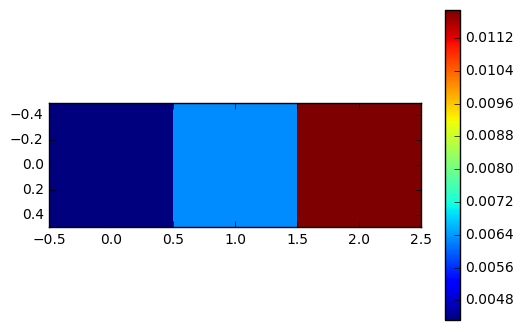

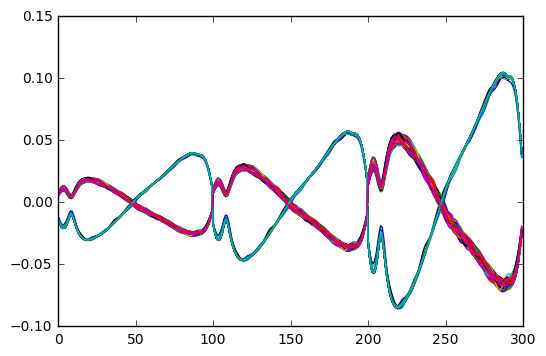

In [27]:
plt.imshow(phiHatExp,interpolation='none')
plt.colorbar()
plt.show()
i=plt.plot(uExpBar.T)
plt.show()

## Training Data in latent Space

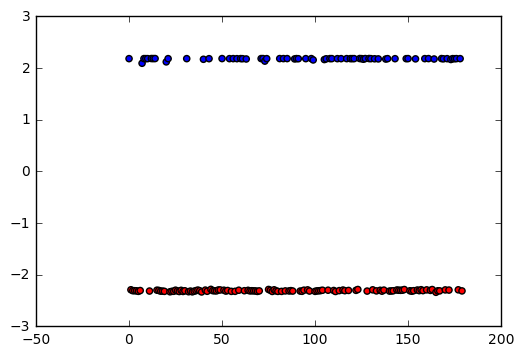

In [15]:
def getColor(l):
    if t < 0:
        return 'r'
    else:
        return 'b'
    
plt.scatter(range(lHatExp.shape[0]),lHatExp,c=[getColor(t) for t in L])


- We see that it's well separated. Too good even

(array([ 12.,   6.,   6.,   6.,  42.,  53.,  82.,  53.,  17.,  23.]),
 array([-0.61169244, -0.5319116 , -0.45213077, -0.37234994, -0.29256911,
        -0.21278827, -0.13300744, -0.05322661,  0.02655423,  0.10633506,
         0.18611589]),
 <a list of 10 Patch objects>)

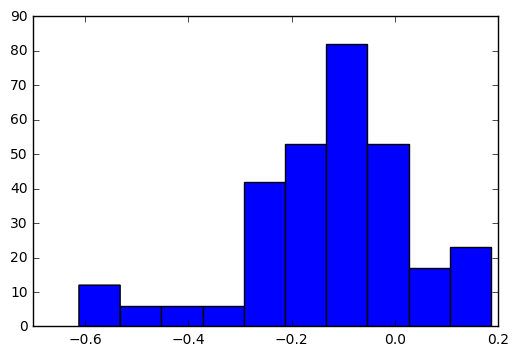

In [44]:
plt.hist(WHatExp.T)

## Now checking performance on test data

In [28]:
Ytest = Y_test
utestHatMeansBar = (Ytest*phiHatExpBar)* KpNn*KpnnInv*uHatVsBar
#Update for u 
M = np.matrix(KpnnInv * KpNn.T)
utestExpBar = utestHatMeansBar * M

In [29]:
ltest=np.zeros(L_test.shape[0])
Lpred=np.zeros(L_test.shape[0])
LpredExp=np.zeros(L_test.shape[0])
ltestHatExp = calculateTNMean(WHatExp*utestExpBar.T + np.ones((Ytest.shape[0],1))*BHatExp[0,0],s=Ytest.shape[0]).reshape(Ytest.shape[0],1)
for t in range(L_test.shape[0]):
    ltest[t] = np.dot(utestExpBar[t,:] ,WHatExp.T) + BHatExp[0,0]
    Lpred[t] = guessLabel(ltest[t])
    LpredExp[t] = guessLabel(ltestHatExp[t])

## Checking separation in latent space

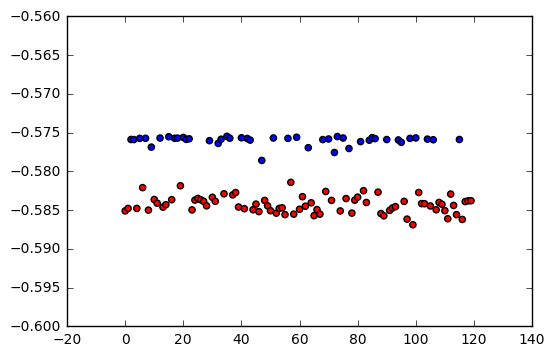

In [30]:
plt.scatter(range(ltest.shape[0]),ltest,c=[getColor(t) for t in L_test])

#### Separation is not visible at all but it looks like scaling issue, i.e. points are separated but by very small gap. A histogram of latent values from test data confirms this: 

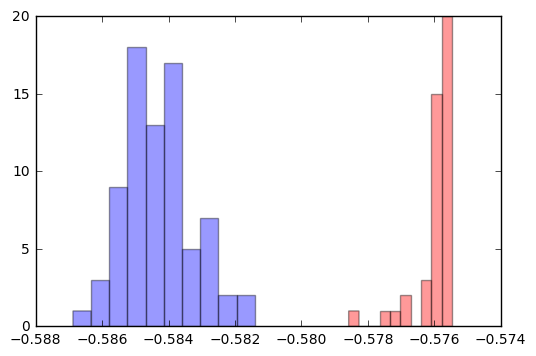

In [31]:
plt.hist(ltest[L_test==1],color='r',alpha=0.4)
plt.hist(ltest[L_test==-1],color='b',alpha=0.4)
plt.show()

In [ ]:
### Rightly slow separation is visible if we zoom in the plot:

(-0.56, -0.59)

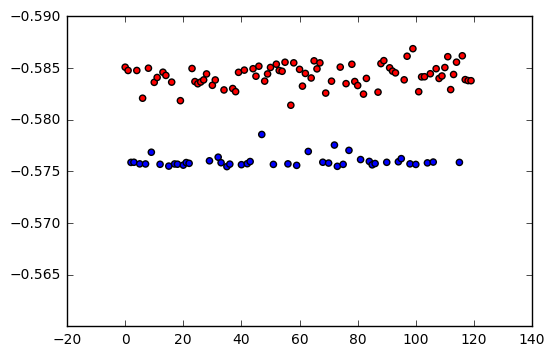

In [32]:
def getColor(l):
    if t < 0:
        return 'r'
    else:
        return 'b'
    
plt.scatter(range(ltest.shape[0]),ltest,c=[getColor(t) for t in L_test])
plt.ylim(-0.56,-0.59)
#plt.plot(L_test)

In [33]:
BHatExp[0,0]

-0.58416022795934286

## In this case bias seems to be a good separater!

### On the other hand if I calculate latent values through truncated normal distribution, scaling issue goes away but also most of the predictive power

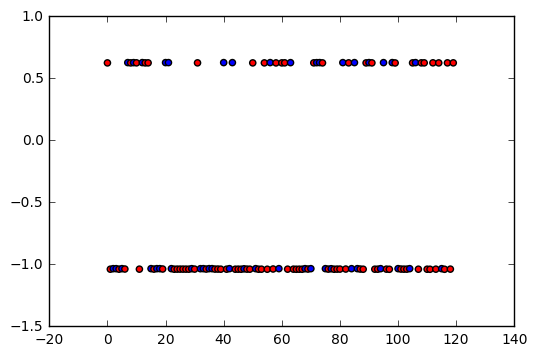

In [21]:
plt.scatter(range(ltestHatExp.shape[0]),ltestHatExp,c=[getColor(t) for t in L_test])